In [159]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc

In [36]:
df = pd.read_csv('.//AB_NYC_2019.csv')

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [38]:
df.isna().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

logit:根据客户喜爱程度，filter/classify data， 找到key element
    根据以上建模，预测price
Data Cleaning:
-replace NA value to 0
-drop id, host_id, host_name

Data scaning:
-plot all numberic vraibles relationship: scatter plot matrix(like R)


Data Analysis:
-Finding relationship between number of review, reviews_permonth, and availability_365 (continue with data scaning, sub plot or regression)

-using name columns: tokenized, anaylsis which character is more poppular to customer ((number of review) * (review per month) as temp popularity column)
--finding most popular 8 string first, and create new column
--ex: new column = 'Sunshie', if exist in value=1

-using latitude and longitude to separate housing to group: uptown, midtown, downtown, etc: check popularity based on location: avg price per night per group
-check price fluctuation based on location
-using regression analysis the relationship between popularity and interested factors
-which neighbourhood/group is most attractive [which is more accurate]
-review frequency and availability,( did the review are all come from extreem review, low availability may means high popularity)
-using new york city.png plot the desenty of airbnb listing

-Logistic reg: y=price, x =  attractive charactor in name, group, neigborhood, neighbourhood_group,minimum_nights
-classification based on name, find the frequency of character to predicted group


# 1) Wrangling and Cleaning the Data

In [39]:
df[df.host_name.isna()].sample(3)
#here, we can find that most nan value are in the column of last_review and review_per_month

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
8163,6292866,Modern Quiet Gem Near All,32722063,NaN,Brooklyn,East Flatbush,40.65263,-73.93215,Entire home/apt,85,2,182,2019-06-19,3.59,2,318
38992,30468335,LARGE Prospect Lefferts Gardens Bedroom,228750026,NaN,Brooklyn,Flatbush,40.65152,-73.95271,Private room,55,7,0,NaN,NaN,1,69
28274,21990808,***SLEEPING IN THE GOLDEN PLACE***,159156636,NaN,Manhattan,Hell's Kitchen,40.75835,-73.99065,Private room,120,1,88,2018-12-14,4.93,3,0


In [40]:
l = pd.DataFrame(df.name.value_counts())

print(l.loc[l.name <= 1].head())
print('\n')
print(f'the total number of the dataset : {len(l)}')

                                                   name
Luxurious Apt in the heart of Manhattan               1
Coworking Style Sublet                                1
Art Lover’s Loft on SoHo/Greenwich Village Border     1
East Harlem room                                      1
Humble and Elegant Place of Comfort                   1


the total number of the dataset : 47905


In [41]:
len(df.loc[df['number_of_reviews'] == 0 ])
# I find here, number_of_reviews are the coresponding value to reviews_per_month, and if
# number_of_reviews == 0, resulting in the reviews_per_month also == 0, so we can just
# assign 0 to the nan in the column of reviews_per_month

10052

### 一些小的想法，就是这里我们发现其实 name 应该代表着的就是公司名，我们是不是可以按照不同公司，名下的公寓数量进行一些分析呢？ host_name 应该指代的是每个特定的房东，会不会分析，每家公司的一些信息，我们也可以发现一些比较好玩的东西。

In [42]:
df.fillna({'reviews_per_month':0}, inplace=True) # replace the nan value in reviews_per_month with 0

In [43]:
df['last_review'] = pd.to_datetime(df['last_review']) # convert the last_review's type to Timestamp
df.last_review.isna().sum()

10052

In [44]:
df.dropna(axis = 0,subset= ['name', 'host_name'], inplace= True) # drop non-significant NaN value in 'name' and 'host_name'

len(df)


48858

In [45]:
df1 = df.drop(columns = ['id', 'host_id','name','host_name','last_review'])

len(df1)

# the back-up dataset for some targets

48858

In [46]:
df1['neighbourhood_group']= df1['neighbourhood_group'].astype("category").cat.codes
df1['neighbourhood'] = df1['neighbourhood'].astype("category").cat.codes
df1['room_type'] = df1['room_type'].astype("category").cat.codes

# convert the cateforical features to int features, for the convinience of doing machine learning later

# 2) Data Exploratory Analysis on price

our team wonder to analysi some interesting features

(1) First, we could explore the feature "host_id", to find the top 10 hosts with the most rooms for renting.

In [99]:
top_host = df.host_id.value_counts().head(10)

In [100]:


top_host_df = pd.DataFrame(top_host)
top_host_df.reset_index(inplace=True)
top_host_df.rename(columns={'index':'Host_ID', 'host_id':'room_Count'}, inplace=True)
top_host_df



,Host_ID,room_Count
0,219517861,327
1,107434423,232
2,30283594,121
3,137358866,103
4,16098958,96
5,12243051,96
6,61391963,91
7,22541573,87
8,200380610,65
9,7503643,52


[Text(0, 0, '7503643'),
 Text(1, 0, '12243051'),
 Text(2, 0, '16098958'),
 Text(3, 0, '22541573'),
 Text(4, 0, '30283594'),
 Text(5, 0, '61391963'),
 Text(6, 0, '107434423'),
 Text(7, 0, '137358866'),
 Text(8, 0, '200380610'),
 Text(9, 0, '219517861')]

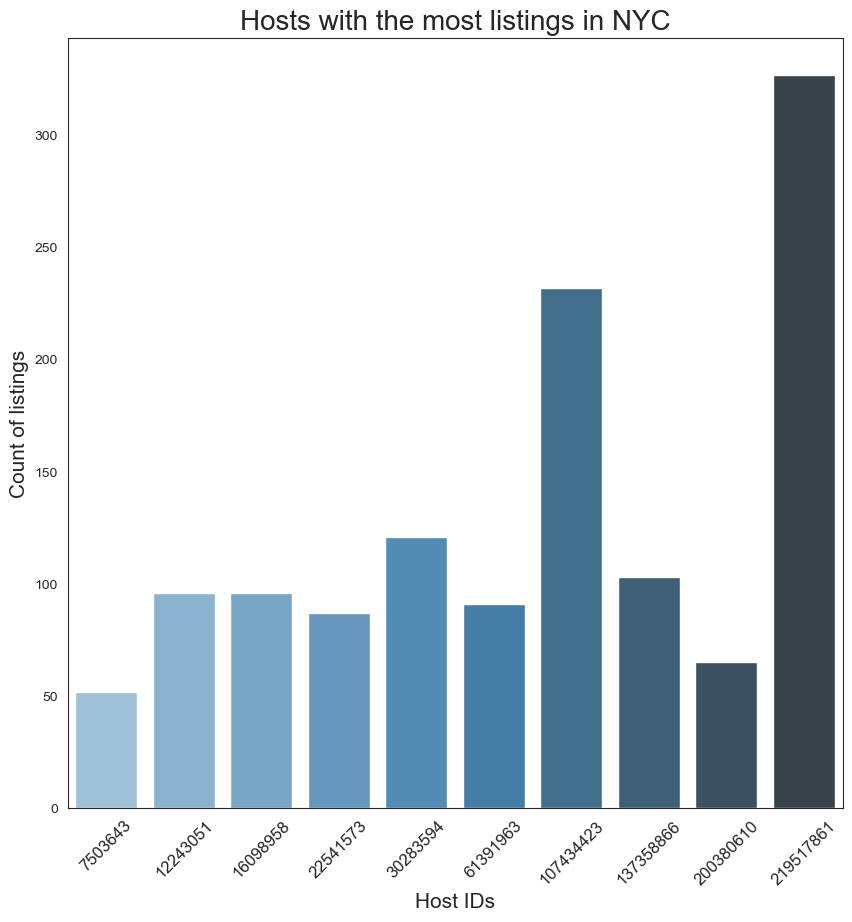

In [101]:
# show the top 10 hosts with the most rooms
plt.figure(figsize= (10,10))
sns.set_style('white')

viz_1 = sns.barplot(x="Host_ID", y="room_Count", data=top_host_df,
                 palette='Blues_d')
viz_1.set_title('Hosts with the most listings in NYC',fontsize = 20)
viz_1.set_ylabel('Count of listings',fontsize = 15)
viz_1.set_xlabel('Host IDs', fontsize = 15)
viz_1.set_xticklabels(viz_1.get_xticklabels(), rotation=45,fontsize = 12)



(2) Explore the features "neighbourhood_group", "neighbour", and "room_type"

In [102]:
df.neighbourhood_group.value_counts()
# here, we can find there exist 5 groups of NYC neibourhood

Manhattan        21643
Brooklyn         20089
Queens            5664
Bronx             1089
Staten Island      373
Name: neighbourhood_group, dtype: int64

In [103]:
# Brooklyn
price_Brooklyn =df.loc[df['neighbourhood_group'] == 'Brooklyn'][['price']]
# Manhattan
price_Manhattan = df.loc[df['neighbourhood_group'] == 'Manhattan'][['price']]

# Queens
price_Queens = df.loc[df['neighbourhood_group'] == 'Queens'][['price']]

# Staten Island
price_StatenIsland = df.loc[df['neighbourhood_group'] == 'Staten Island'][['price']]

# Bronx
price_Bronx = df.loc[df['neighbourhood_group'] == 'Bronx'][['price']]

# putting all the prices' dfs in the list
price_list_by_nei = [price_Brooklyn, price_Manhattan, price_Queens, price_StatenIsland, price_Bronx]


In [104]:
# creating an empty list that we will append later with price distributions for each neighbourhood_group
p_l_b_n_2=[]

# creating list with known values in neighbourhood_group column
nei_list=['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx']

# creating a for loop to get statistics for price ranges and append it to our empty list
for x in price_list_by_nei:
    i=x.describe(percentiles=[.25, .50, .75])
    i=i.iloc[3:]
    i.reset_index(inplace=True)
    i.rename(columns={'index':'Stats'}, inplace=True)
    p_l_b_n_2.append(i)

# changing names of the price column to the area name for easier reading of the table    
p_l_b_n_2[0].rename(columns={'price':nei_list[0]}, inplace=True)
p_l_b_n_2[1].rename(columns={'price':nei_list[1]}, inplace=True)
p_l_b_n_2[2].rename(columns={'price':nei_list[2]}, inplace=True)
p_l_b_n_2[3].rename(columns={'price':nei_list[3]}, inplace=True)
p_l_b_n_2[4].rename(columns={'price':nei_list[4]}, inplace=True)

# inilizing our dataframe for final view    
stat_df=p_l_b_n_2
stat_df=[df.set_index('Stats') for df in stat_df]
stat_df=stat_df[0].join(stat_df[1:])
stat_df

,Brooklyn,Manhattan,Queens,Staten Island,Bronx
Stats,,,,,
min,0.0,0.0,10.0,13.0,0.0
25%,60.0,95.0,50.0,50.0,45.0
50%,90.0,150.0,75.0,75.0,65.0
75%,150.0,220.0,110.0,110.0,99.0
max,10000.0,10000.0,10000.0,5000.0,2500.0


Text(0, 0.5, 'price')

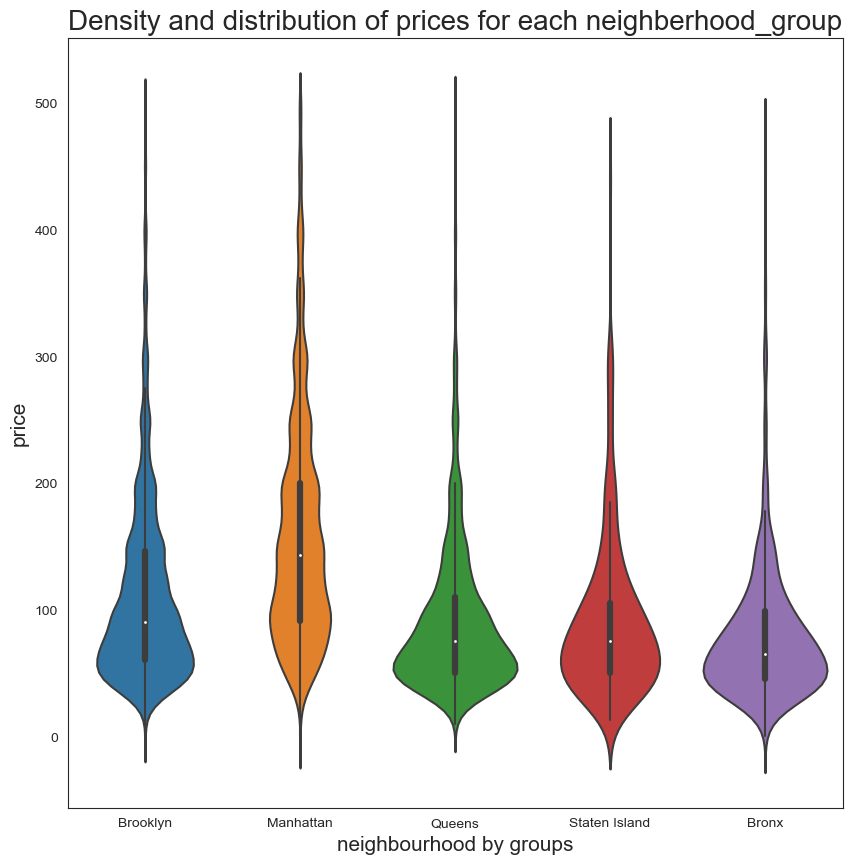

In [106]:
# we can see from our statistical table that we have some extreme values, 
# therefore we need to remove them for the sake of a better visualization

# creating a sub-dataframe with no extreme values  less than 500
sub = df[df.price < 500]
# using violinplot to showcase density and distribtuion of prices 

plt.figure(figsize = (10,10))
viz_2 = sns.violinplot(data=sub, x='neighbourhood_group', y='price')
viz_2.set_title('Density and distribution of prices for each neighberhood_group',fontsize = 20)
viz_2.set_xlabel('neighbourhood by groups', fontsize = 15)
viz_2.set_ylabel('price', fontsize = 15)



here, we can find the statistical distribution of each neighbourhood groups, and also their quantiles

In [107]:
df['neighbourhood'].value_counts()[:10]
# top 10 neighbourhood with the most renting rooms

Williamsburg          3917
Bedford-Stuyvesant    3713
Harlem                2655
Bushwick              2462
Upper West Side       1969
Hell's Kitchen        1954
East Village          1852
Upper East Side       1797
Crown Heights         1563
Midtown               1545
Name: neighbourhood, dtype: int64

<Figure size 1000x1500 with 0 Axes>

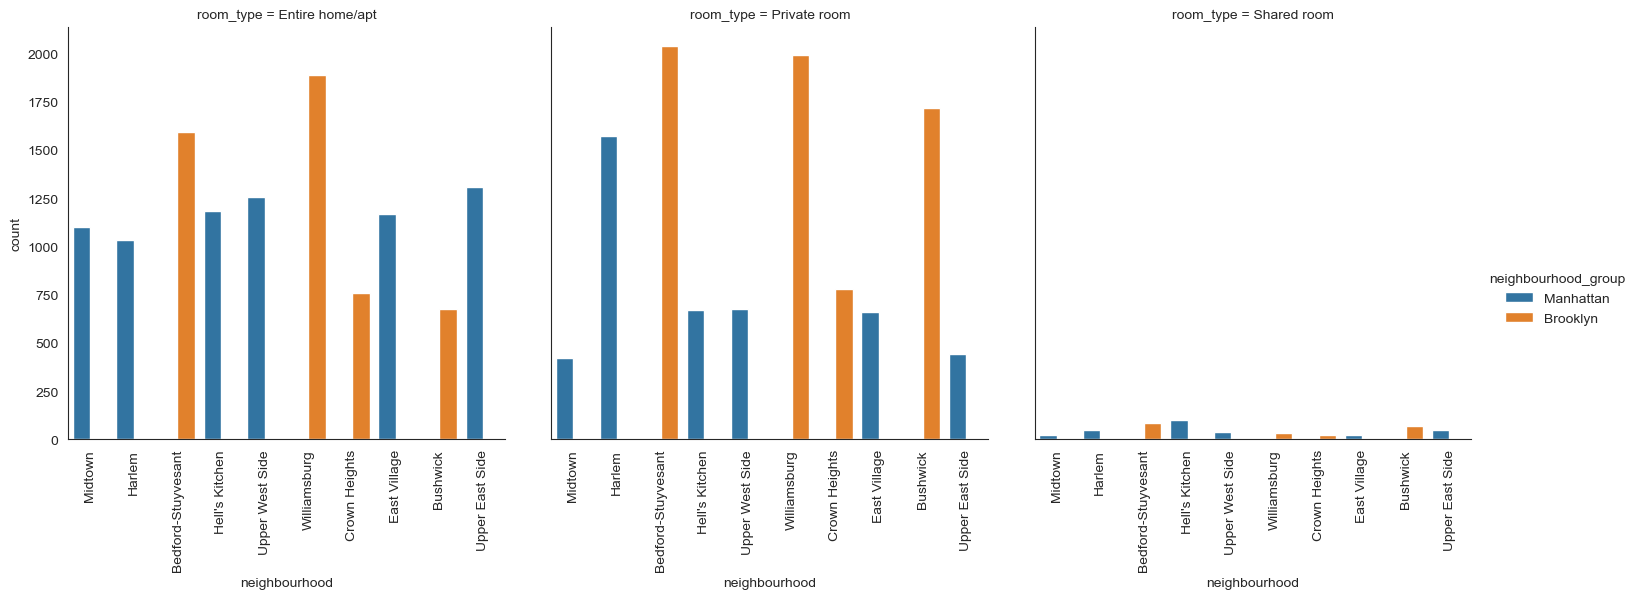

In [108]:
# then, we could visualize the room_type distribution based on the top 10 neighbourhood

# grabbing top 10 neighbourhoods for sub-dataframe
sub2 = df.loc[df['neighbourhood'].isin(['Williamsburg','Bedford-Stuyvesant','Harlem','Bushwick',
                 'Upper West Side',"Hell's Kitchen",'East Village','Upper East Side','Crown Heights','Midtown'])]

# using catplot to represent multiple interesting attributes together and with the # of counts

plt.figure(figsize=(10,15))
viz_3=sns.catplot(x='neighbourhood', hue='neighbourhood_group', col='room_type', data=sub2, kind='count')
viz_3.set_xticklabels(rotation=90)

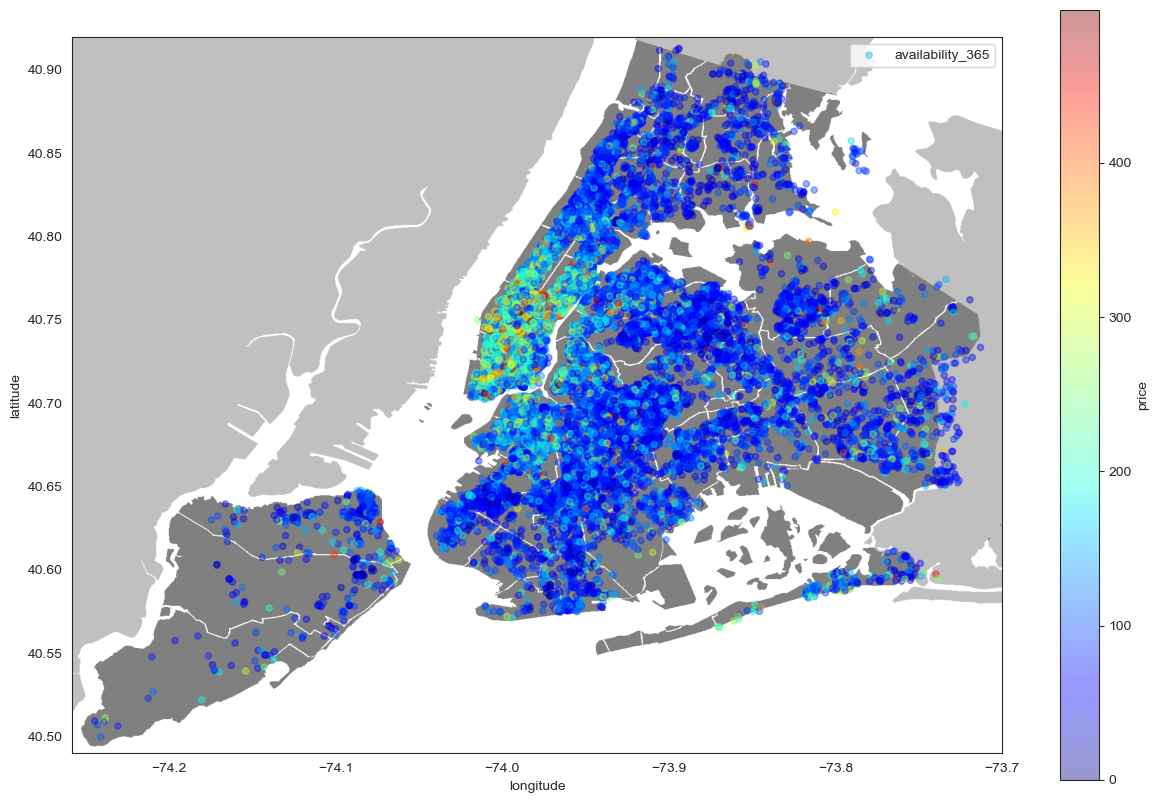

In [113]:
import urllib.request

url = 'https://upload.wikimedia.org/wikipedia/commons/e/ec/Neighbourhoods_New_York_City_Map.PNG'

# Opening the URL and reading the image data
with urllib.request.urlopen(url) as response:
    nyc_img = plt.imread(response, format='PNG')

plt.figure(figsize= (15,10))

# scaling the image based on the latitude and longitude max and mins for proper output
plt.imshow(nyc_img,zorder=0,extent=[-74.258, -73.7, 40.49,40.92])
ax = plt.gca()

# using scatterplot
sub.plot(kind='scatter', x='longitude', y='latitude', label='availability_365', c='price', ax=ax, 
           cmap=plt.get_cmap('jet'), colorbar=True, alpha=0.4, zorder=5)

plt.legend()
plt.show()



(3) show the most popular prompts in searching

In [114]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag

# Download required NLTK resources
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

def tokenize_and_filter(text):
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words and token.isalnum()]
    tagged_tokens = pos_tag(filtered_tokens)
    nouns_verbs = [token for token, pos in tagged_tokens if pos.startswith('N') or pos.startswith('V') or pos.startswith('ADJ') or pos.startswith('NUM')]
    return nouns_verbs

[nltk_data] Downloading package punkt to /Users/north/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/north/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /Users/north/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [115]:
df['tokenized_name'] = df['name'].apply(tokenize_and_filter)

In [116]:
df['name'][:10]

0                  Clean & quiet apt home by the park
1                               Skylit Midtown Castle
2                 THE VILLAGE OF HARLEM....NEW YORK !
3                     Cozy Entire Floor of Brownstone
4    Entire Apt: Spacious Studio/Loft by central park
5           Large Cozy 1 BR Apartment In Midtown East
6                                     BlissArtsSpace!
7                    Large Furnished Room Near B'way 
8                  Cozy Clean Guest Room - Family Apt
9                  Cute & Cozy Lower East Side 1 bdrm
Name: name, dtype: object

In [117]:
df['tokenized_name'][:10]

0                             [home, park]
1                [Skylit, Midtown, Castle]
2             [VILLAGE, HARLEM, NEW, YORK]
3        [Cozy, Entire, Floor, Brownstone]
4            [Entire, Apt, Spacious, park]
5     [Cozy, BR, Apartment, Midtown, East]
6                         [BlissArtsSpace]
7                        [Furnished, Room]
8        [Clean, Guest, Room, Family, Apt]
9    [Cute, Cozy, Lower, East, Side, bdrm]
Name: tokenized_name, dtype: object

In [118]:
names_for_count_=[]
#getting name string from our list and using split function, later appending to list above

for token in df['tokenized_name']:
    for word in token:
        word = word.lower()
        names_for_count_.append(word)

In [119]:
#we are going to use counter
from collections import Counter
#let's see top 25 used words by host to name their listing
top_25_w = Counter(names_for_count_).most_common()
top_25_w = top_25_w[0:25]

In [121]:
#now let's put our findings in dataframe for further visualizations
plot_words = pd.DataFrame(top_25_w)
plot_words.rename(columns={0:'Words', 1:'Count'}, inplace=True)

[Text(0, 0, 'room'),
 Text(1, 0, 'bedroom'),
 Text(2, 0, 'apartment'),
 Text(3, 0, 'cozy'),
 Text(4, 0, 'brooklyn'),
 Text(5, 0, 'studio'),
 Text(6, 0, 'apt'),
 Text(7, 0, 'manhattan'),
 Text(8, 0, 'park'),
 Text(9, 0, 'east'),
 Text(10, 0, 'private'),
 Text(11, 0, 'williamsburg'),
 Text(12, 0, 'village'),
 Text(13, 0, 'nyc'),
 Text(14, 0, 'sunny'),
 Text(15, 0, 'heart'),
 Text(16, 0, 'home'),
 Text(17, 0, 'loft'),
 Text(18, 0, 'luxury'),
 Text(19, 0, 'central'),
 Text(20, 0, 'location'),
 Text(21, 0, 'bed'),
 Text(22, 0, 'west'),
 Text(23, 0, 'side'),
 Text(24, 0, 'charming')]

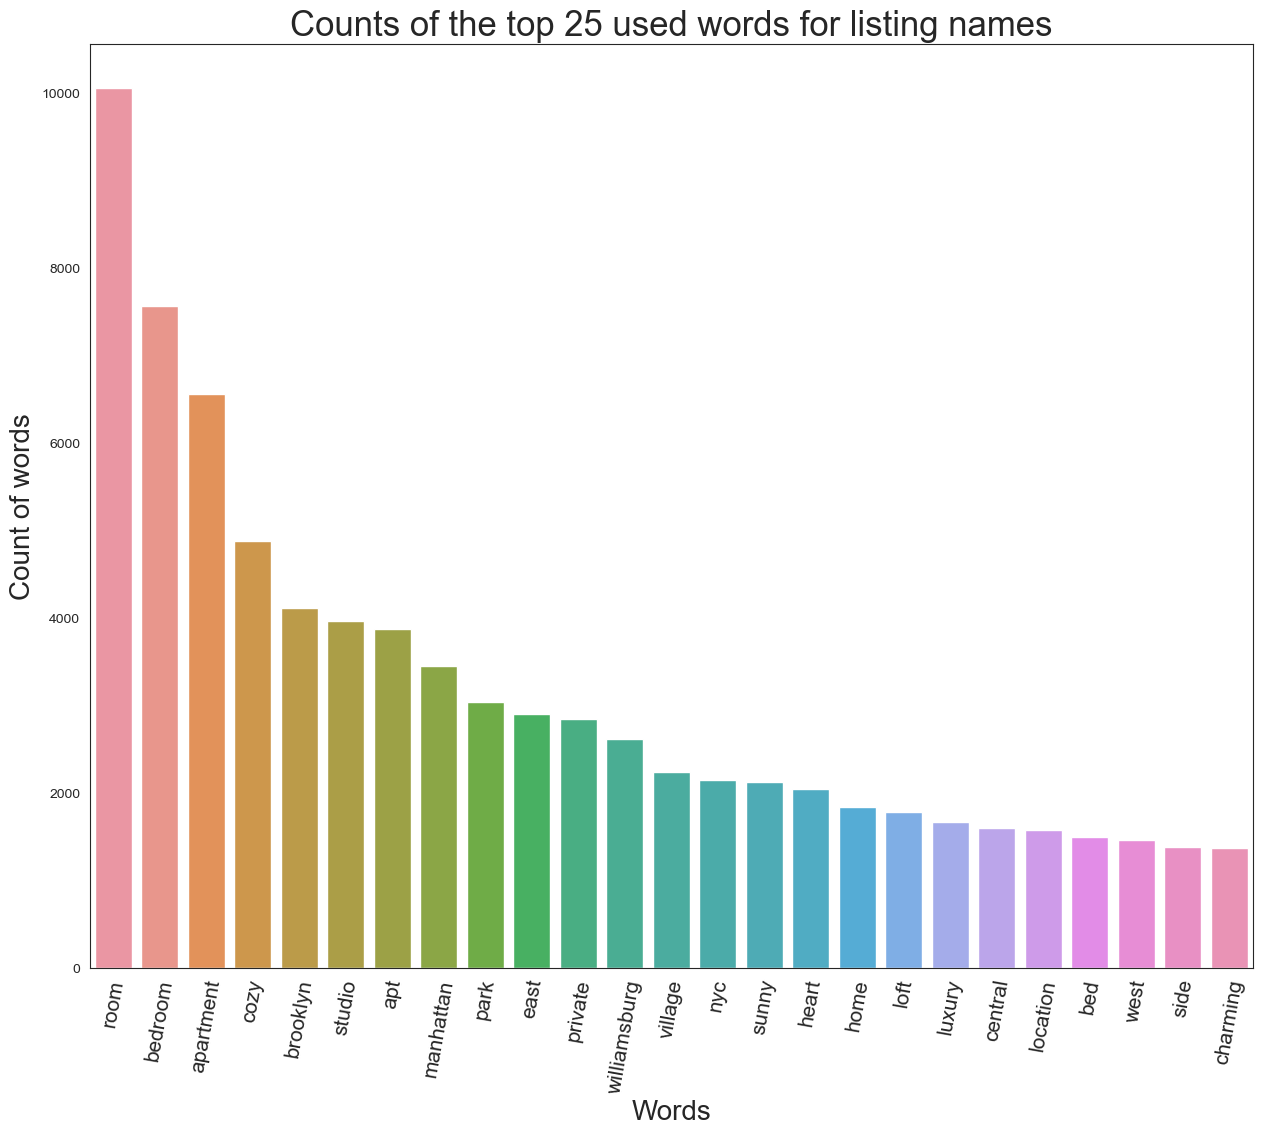

In [122]:
#we are going to use barplot for this visualization
plt.figure(figsize = (15,12))
viz_5=sns.barplot(x='Words', y='Count', data= plot_words)
viz_5.set_title('Counts of the top 25 used words for listing names', fontsize = 25)
viz_5.set_ylabel('Count of words', fontsize = 20)
viz_5.set_xlabel('Words',fontsize = 20)
viz_5.set_xticklabels(viz_5.get_xticklabels(), rotation=80, fontsize = 15)

(4) prepare for building the model

/Users/north/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Price Distribution Plot')

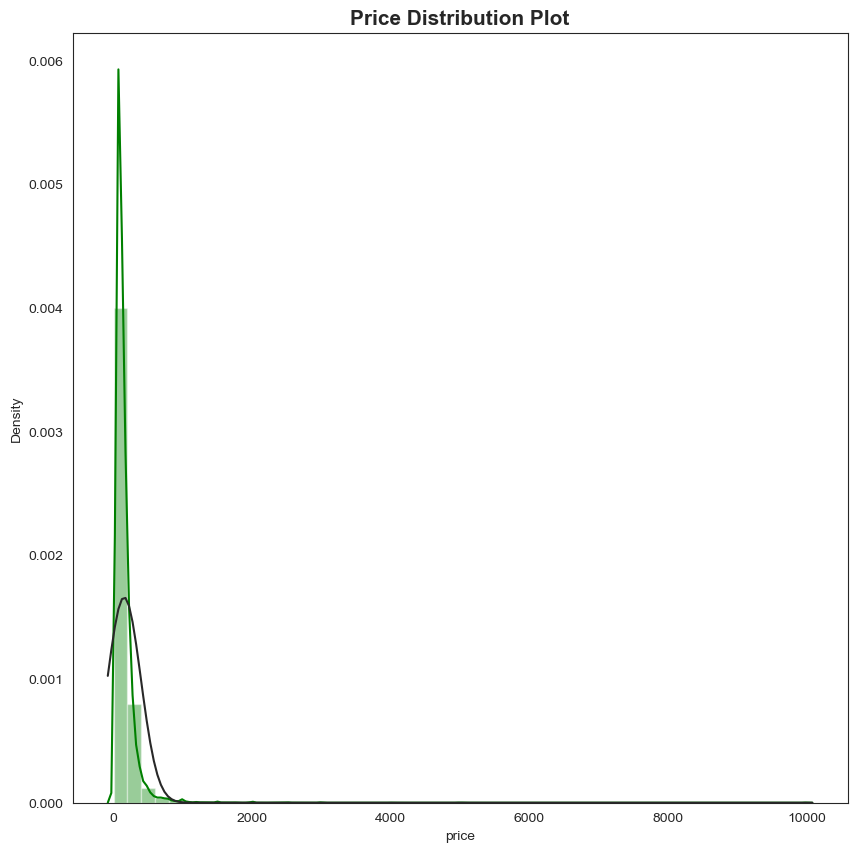

In [123]:
# a) the normal plot of 'price'
plt.figure(figsize=(10,10))

sns.distplot(df1['price'], fit=norm, color='g')

plt.title("Price Distribution Plot",size=15, weight='bold')


In [124]:
# Create a new column 'price_dummy' in df1 based on the median price
df1['price_dummy'] = [0 if x < df['price'].median() else 1 for x in df['price']]

we also find that this bell-shape distribution of price have skewness on the right side too much, so we would logalize the price to make it more normal

In [125]:
df1['price_log'] = np.log(df1.price + 1) # add 1 to avoid the appearance of log0

/Users/north/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'price_log Distribution Plot')

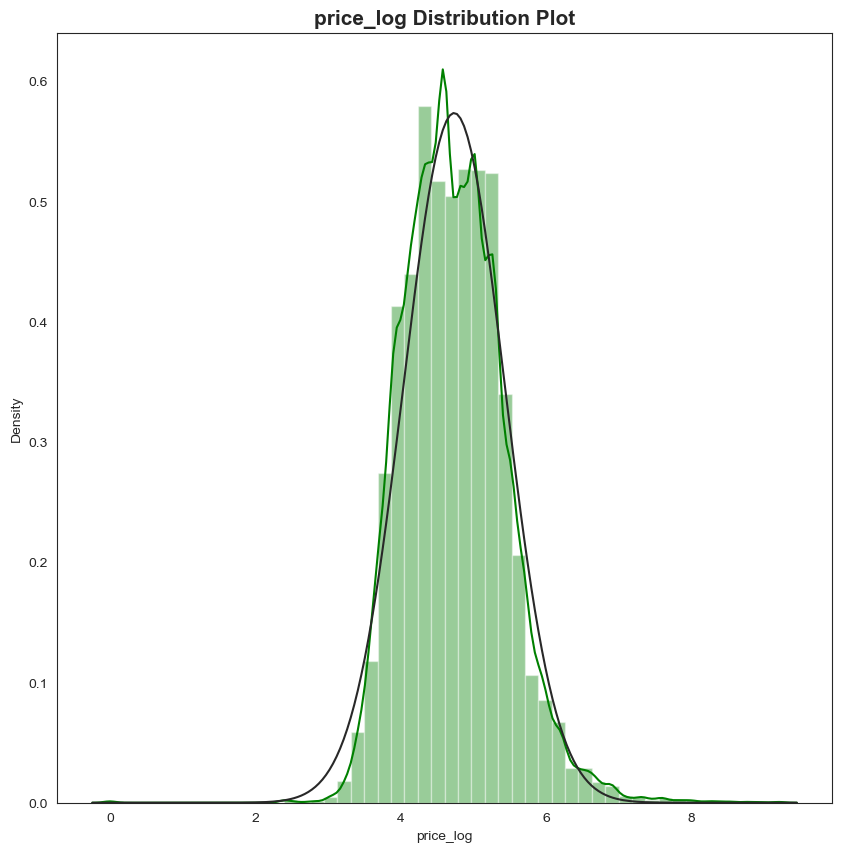

In [126]:
plt.figure(figsize=(10,10))

sns.distplot(df1['price_log'], fit=norm, color='g')

plt.title("price_log Distribution Plot",size=15, weight='bold')

b) Q-Q plot of 'price_log'

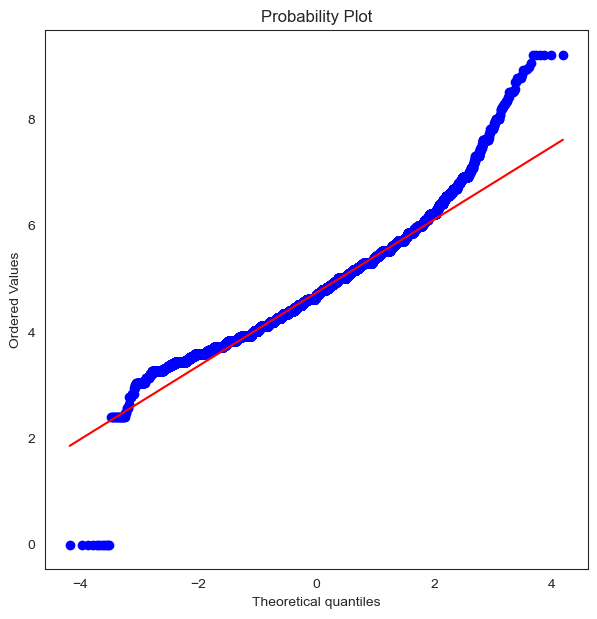

In [127]:
# Draw the Q-Q plot, which reveal the normality of 'price_log'

plt.figure(figsize=(7,7))

stats.probplot(df1['price_log'], plot=plt)

plt.show()



In [128]:
df1.drop(columns=['price'],inplace= True)
df1.columns

Index(['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude',
       'room_type', 'minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365', 'price_dummy',
       'price_log'],
      dtype='object')

c) correlation plot

Text(0.5, 1.0, 'Correlation Matrix')

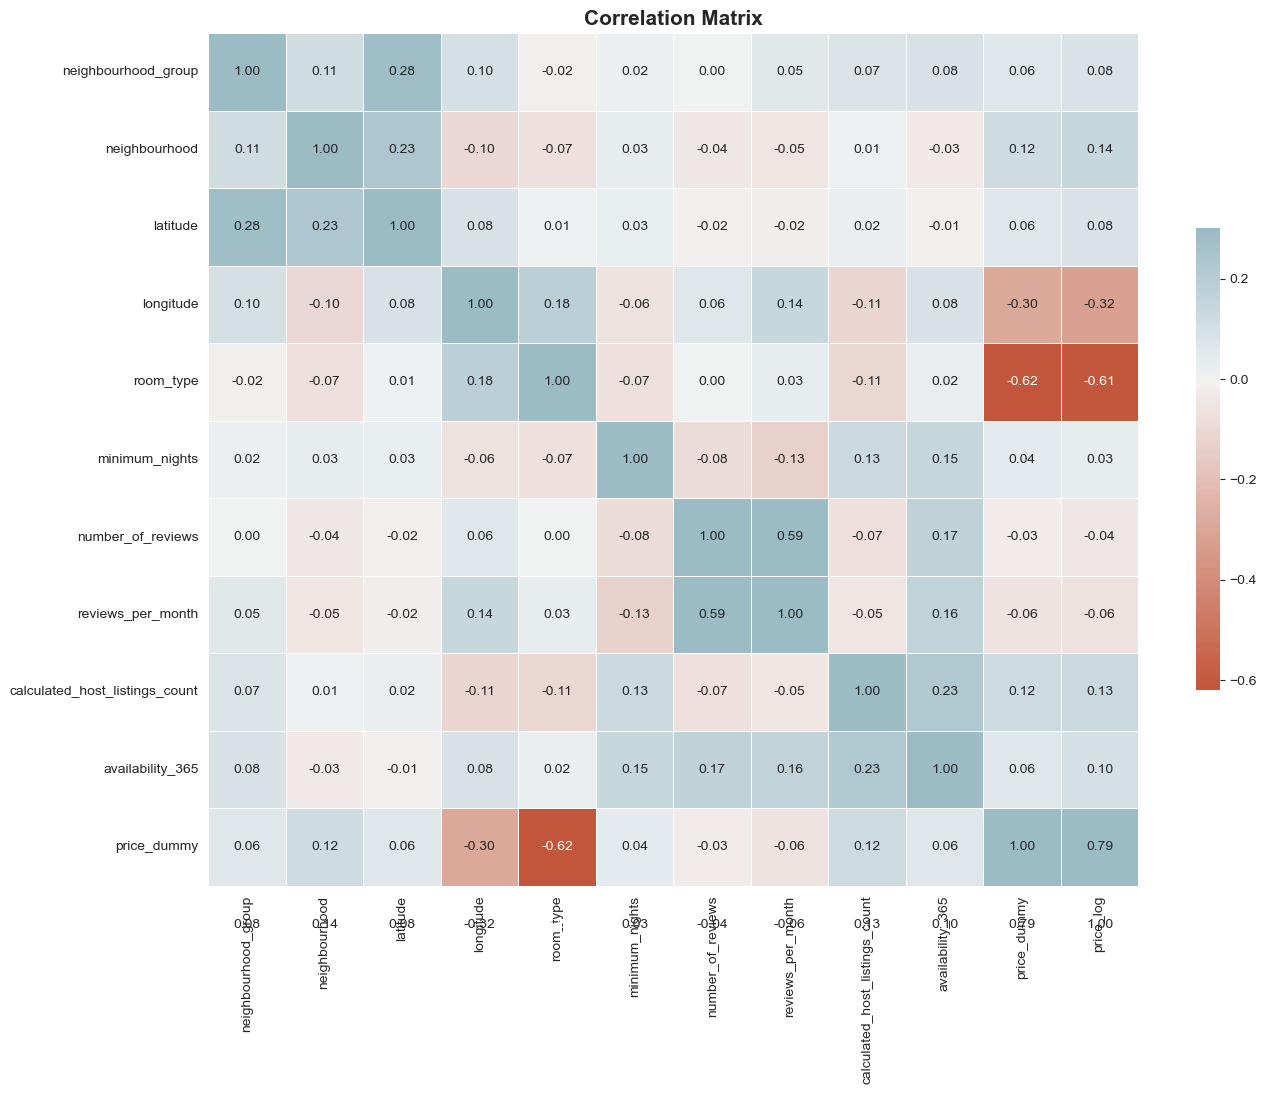

In [129]:
# Provide the correlation between each feature

plt.figure(figsize=(15,12))

palette = sns.diverging_palette(20, 220, n=256)

corr=df1.corr(method='pearson')

sns.heatmap(corr, annot=True, fmt=".2f", cmap=palette, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set(ylim=(11, 0))

plt.title("Correlation Matrix",size=15, weight='bold')



/Users/north/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/north/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/north/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn

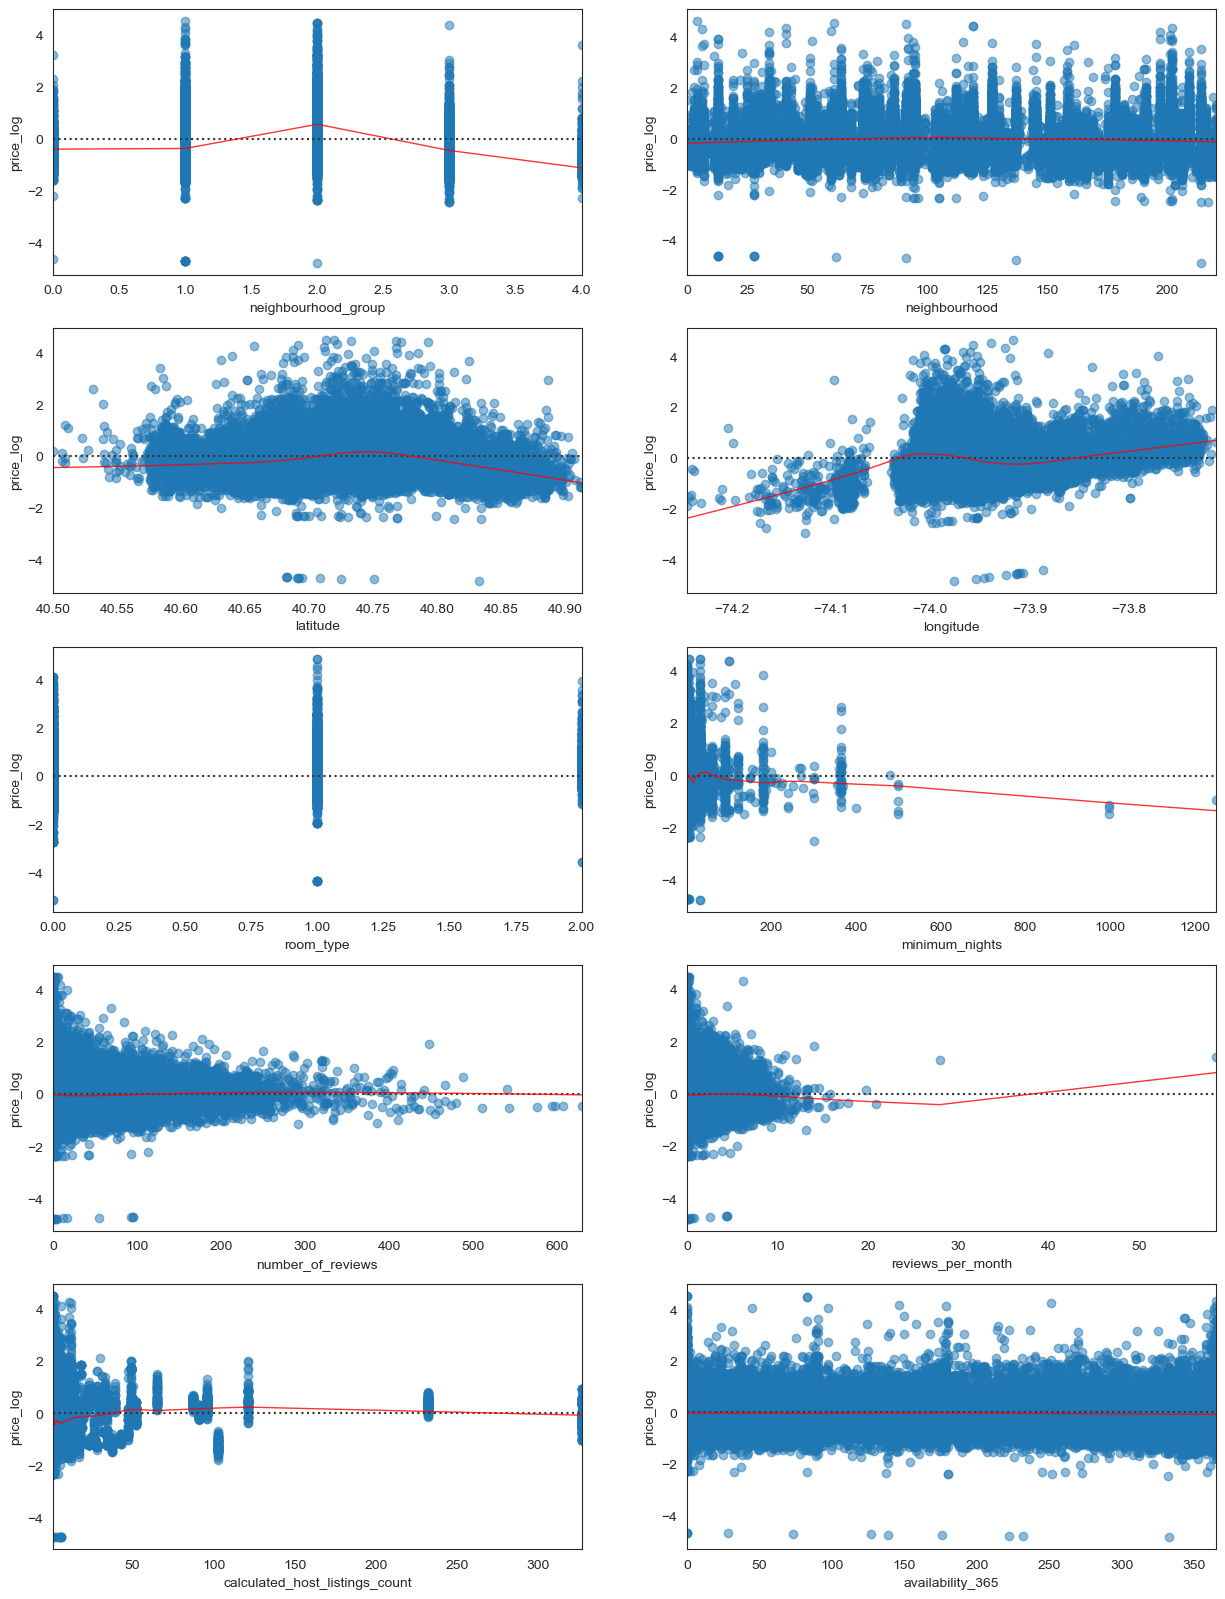

In [130]:

# then, we also need to detect the outlier and linearity between price_log and other features, by Residual-Plots

fig, axes = plt.subplots(5, 2, figsize=(15, 20))

index = 0

for i in range(5):
    for j in range(2):

        sns.residplot(df1.iloc[:,index],df1.iloc[:,-1],
                      lowess=True, ax=axes[i, j], scatter_kws={'alpha': 0.5},
                      line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
        index += 1



tokenization

In [131]:
import nltk 
from nltk.corpus import stopwords
from string import punctuation
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/north/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/north/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /Users/north/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [132]:
tokenized=df['name'].apply(lambda row: nltk.word_tokenize(row))

In [133]:
tokenized.head()

0          [Clean, &, quiet, apt, home, by, the, park]
1                            [Skylit, Midtown, Castle]
2       [THE, VILLAGE, OF, HARLEM, ...., NEW, YORK, !]
3                [Cozy, Entire, Floor, of, Brownstone]
4    [Entire, Apt, :, Spacious, Studio/Loft, by, ce...
Name: name, dtype: object

In [134]:
stop_words = set(stopwords.words('english'))
punctuations = set(punctuation)
def remove_stopwords(tokens):
    return [token for token in tokens if token.lower() not in stop_words and token not in punctuations]

In [135]:
#break a list of lists into one single list
tokenized=sum(tokenized,[])

In [136]:
tokenized[:8]

['Clean', '&', 'quiet', 'apt', 'home', 'by', 'the', 'park']

In [137]:
#delete all stop words, punctuations, conjunctions, and numbers from the list
filtered_tokens = remove_stopwords(tokenized)
decapitalized_tokens = [word.lower() for word in filtered_tokens]
only_word = [word for word in decapitalized_tokens if not word.isdigit()]
only_word[:8]

['clean', 'quiet', 'apt', 'home', 'park', 'skylit', 'midtown', 'castle']

In [138]:
#delete room type and neighborhood words from the list
import re
text = ' '.join(df['neighbourhood_group'].tolist() + df['neighbourhood'].tolist() + df['room_type'].tolist())
words = re.findall(r'\w+', text)
word_set = set(words)
word_list=list(word_set)
dec_word_list=[word.lower() for word in word_list]
print(dec_word_list[:5])
only_word_new=[word for word in only_word if word not in dec_word_list]
print(only_word_new[:5])

['longwood', 'kitchen', 'east', 'brighton', 'manhattan']
['clean', 'quiet', 'skylit', '....', 'cozy']


In [139]:
#manually remove pointless words from list
pointless=['bedroom','apartment','studio','nyc','....','1br',"'s",'house','place']
only_word_new=[word for word in only_word_new if word not in pointless]
print(only_word_new[:5])

['clean', 'quiet', 'skylit', 'cozy', 'floor']


In [140]:
from collections import Counter

word_counts = Counter(only_word_new)

top_words = word_counts.most_common(10)
print(top_words)

[('cozy', 5032), ('spacious', 3741), ('sunny', 2900), ('beautiful', 2488), ('near', 2327), ('heart', 2051), ('large', 2047), ('loft', 2000), ('modern', 1783), ('central', 1759)]


Text(0.5, 1.0, 'Word Frequency Bar Chart')

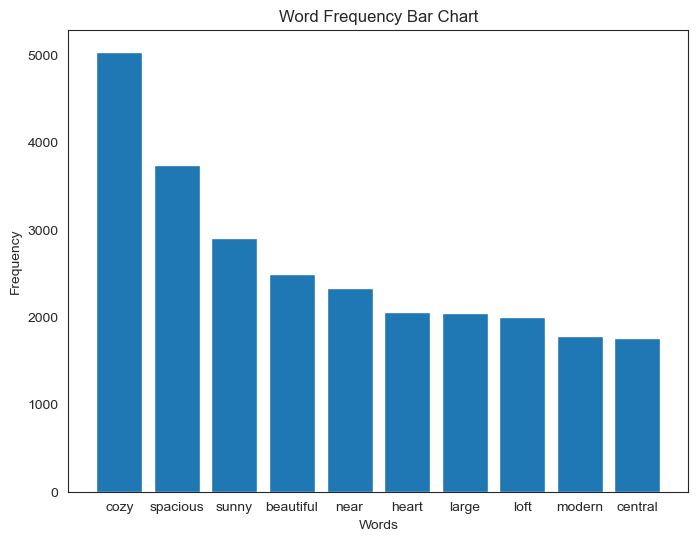

In [141]:
fig = plt.figure(figsize=(8, 6))
plt.bar(dict(top_words).keys(), dict(top_words).values())
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word Frequency Bar Chart')

In [142]:
df['neighbourhood_group'].unique()

array(['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx'],
      dtype=object)

In [143]:
df_Brooklyn=df[df['neighbourhood_group']=='Brooklyn']
df_Manhattan=df[df['neighbourhood_group']=='Manhattan']
df_Queens=df[df['neighbourhood_group']=='Queens']
df_Staten_Island=df[df['neighbourhood_group']=='Staten Island']
df_Bronx=df[df['neighbourhood_group']=='Bronx']

In [144]:
tok_Brooklyn=df_Brooklyn['name'].apply(lambda row: nltk.word_tokenize(row))
tok_Brooklyn=sum(tok_Brooklyn,[])

tok_Manhattan=df_Manhattan['name'].apply(lambda row: nltk.word_tokenize(row))
tok_Manhattan=sum(tok_Manhattan,[])

tok_Queens=df_Queens['name'].apply(lambda row: nltk.word_tokenize(row))
tok_Queens=sum(tok_Queens,[])

tok_Staten_Island=df_Staten_Island['name'].apply(lambda row: nltk.word_tokenize(row))
tok_Staten_Island=sum(tok_Staten_Island,[])

tok_Bronx=df_Bronx['name'].apply(lambda row: nltk.word_tokenize(row))
tok_Bronx=sum(tok_Bronx,[])

In [145]:
#prepare for Brooklyn
filtered_tokens_Brooklyn = remove_stopwords(tok_Brooklyn)
decapitalized_tokens_Brooklyn = [word.lower() for word in filtered_tokens_Brooklyn]
only_word_Brooklyn = [word for word in decapitalized_tokens_Brooklyn if not word.isdigit()]
only_word_Brooklyn=[word for word in only_word_Brooklyn if word not in dec_word_list]
only_word_Brooklyn=[word for word in only_word_Brooklyn if word not in pointless]
only_word_Brooklyn[:8]

word_counts_Brooklyn = Counter(only_word_Brooklyn)

top_words_Brooklyn = word_counts_Brooklyn.most_common(10)
print(top_words_Brooklyn)

[('cozy', 2016), ('spacious', 1756), ('sunny', 1681), ('loft', 1233), ('beautiful', 1213), ('brownstone', 949), ('bright', 927), ('large', 836), ('modern', 833), ('heart', 789)]


Text(0.5, 1.0, 'Word Frequency Bar Chart for Brooklyn')

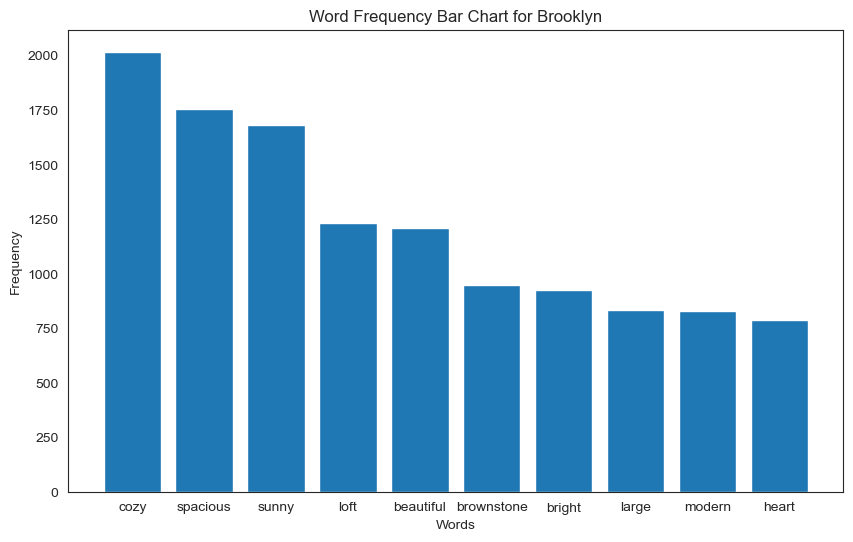

In [146]:
fig = plt.figure(figsize=(10, 6))
plt.bar(dict(top_words_Brooklyn).keys(), dict(top_words_Brooklyn).values())
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word Frequency Bar Chart for Brooklyn')

In [147]:
#prepare for Manhattan
filtered_tokens_Manhattan = remove_stopwords(tok_Manhattan)
decapitalized_tokens_Manhattan = [word.lower() for word in filtered_tokens_Manhattan]
only_word_Manhattan = [word for word in decapitalized_tokens_Manhattan if not word.isdigit()]
only_word_Manhattan=[word for word in only_word_Manhattan if word not in dec_word_list]
only_word_Manhattan=[word for word in only_word_Manhattan if word not in pointless]
only_word_Manhattan[:8]

word_counts_Manhattan = Counter(only_word_Manhattan)

top_words_Manhattan = word_counts_Manhattan.most_common(10)
print(top_words_Manhattan)

[('cozy', 2079), ('central', 1621), ('spacious', 1529), ('near', 1159), ('heart', 1124), ('luxury', 1073), ('location', 1018), ('sunny', 988), ('beautiful', 980), ('large', 917)]


Text(0.5, 1.0, 'Word Frequency Bar Chart for Manhattan')

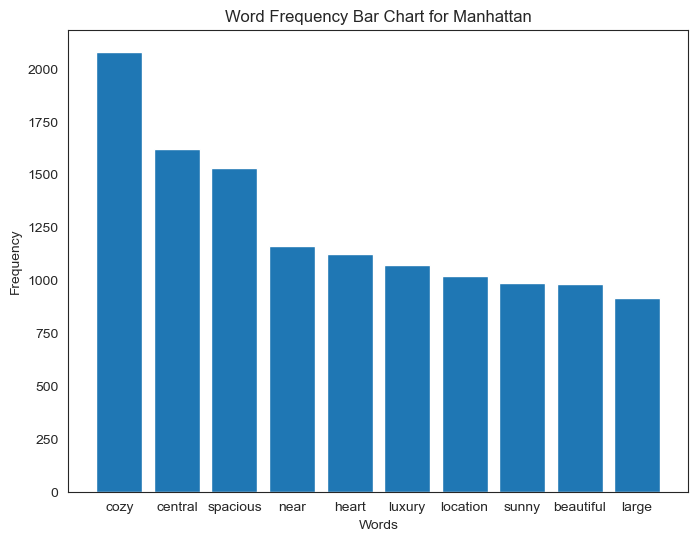

In [148]:
fig = plt.figure(figsize=(8, 6))
plt.bar(dict(top_words_Manhattan).keys(), dict(top_words_Manhattan).values())
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word Frequency Bar Chart for Manhattan')

In [149]:
#prepare for Queens
filtered_tokens_Queens = remove_stopwords(tok_Queens)
decapitalized_tokens_Queens = [word.lower() for word in filtered_tokens_Queens]
only_word_Queens = [word for word in decapitalized_tokens_Queens if not word.isdigit()]
only_word_Queens=[word for word in only_word_Queens if word not in dec_word_list]
only_word_Queens=[word for word in only_word_Queens if word not in pointless]
only_word_Queens[:8]

word_counts_Queens = Counter(only_word_Queens)

top_words_Queens = word_counts_Queens.most_common(10)
print(top_words_Queens)

[('cozy', 767), ('jfk', 464), ('near', 427), ('spacious', 366), ('min', 337), ('close', 307), ('lga', 285), ('beautiful', 241), ('large', 223), ('mins', 222)]


Text(0.5, 1.0, 'Word Frequency Bar Chart for Queens')

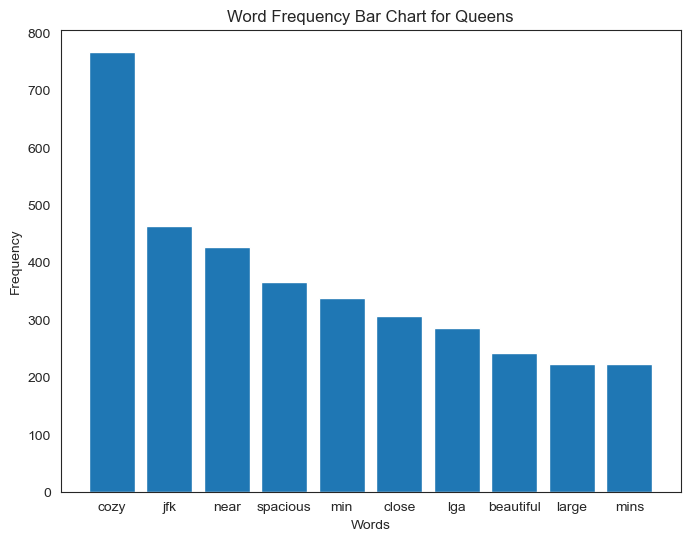

In [150]:
fig = plt.figure(figsize=(8, 6))
plt.bar(dict(top_words_Queens).keys(), dict(top_words_Queens).values())
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word Frequency Bar Chart for Queens')

In [151]:
#prepare for Staten_Island
filtered_tokens_Staten_Island = remove_stopwords(tok_Staten_Island)
decapitalized_tokens_Staten_Island = [word.lower() for word in filtered_tokens_Staten_Island]
only_word_Staten_Island = [word for word in decapitalized_tokens_Staten_Island if not word.isdigit()]
only_word_Staten_Island=[word for word in only_word_Staten_Island if word not in dec_word_list]
only_word_Staten_Island=[word for word in only_word_Staten_Island if word not in pointless]
only_word_Staten_Island[:8]

word_counts_Staten_Island = Counter(only_word_Staten_Island)

top_words_Staten_Island = word_counts_Staten_Island.most_common(10)
print(top_words_Staten_Island)

[('ferry', 60), ('cozy', 47), ('near', 35), ('spacious', 22), ('free', 19), ('close', 17), ('beautiful', 15), ('charming', 14), ('si', 13), ('renovated', 13)]


Text(0.5, 1.0, 'Word Frequency Bar Chart for Staten_Island')

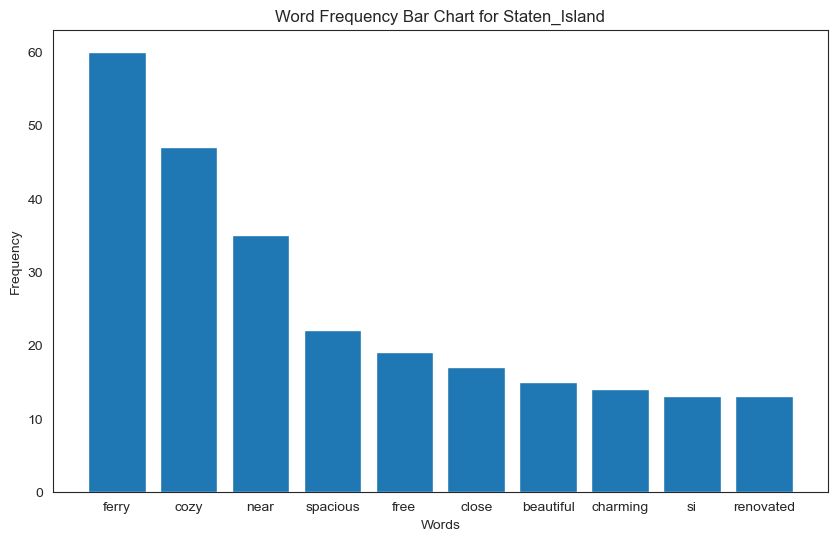

In [152]:
fig = plt.figure(figsize=(10, 6))
plt.bar(dict(top_words_Staten_Island).keys(), dict(top_words_Staten_Island).values())
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word Frequency Bar Chart for Staten_Island')

In [153]:
#prepare for Bronx
filtered_tokens_Bronx = remove_stopwords(tok_Bronx)
decapitalized_tokens_Bronx = [word.lower() for word in filtered_tokens_Bronx]
only_word_Bronx = [word for word in decapitalized_tokens_Bronx if not word.isdigit()]
only_word_Bronx=[word for word in only_word_Bronx if word not in dec_word_list]
only_word_Bronx=[word for word in only_word_Bronx if word not in pointless]
only_word_Bronx[:8]

word_counts_Bronx = Counter(only_word_Bronx)

top_words_Bronx = word_counts_Bronx.most_common(10)
print(top_words_Bronx)

[('cozy', 123), ('near', 70), ('spacious', 68), ('large', 60), ('yankee', 55), ('stadium', 53), ('beautiful', 39), ('modern', 33), ('close', 32), ('subway', 30)]


# 3) Compare different models upon predicting price

### a) Set up training and test sets

In [163]:
# split data into training and test sets
X = df1[['neighbourhood_group','neighbourhood','room_type','minimum_nights','number_of_reviews',
         'reviews_per_month','calculated_host_listings_count','availability_365']]
y1 = df1['price_log']
y2 = df1['price_dummy']
X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(X, y1, y2, test_size = 0.2, random_state = 100)

### b) Predict 'price_log'

In [57]:
# Initialize the models
linear = LinearRegression()
lasso = Lasso()
ridge = Ridge()
gbr = GradientBoostingRegressor()
# Train the models
linear.fit(X_train, y1_train)
lasso.fit(X_train, y1_train)
ridge.fit(X_train, y1_train)
gbr.fit(X_train, y1_train)
# Predict prices on the test set
linear_pred = linear.predict(X_test)
lasso_pred = lasso.predict(X_test)
ridge_pred = ridge.predict(X_test)
gbr_pred = gbr.predict(X_test)
# Calculate mean squared error and R^2 score
linear_MSE = mean_squared_error(y1_test, gbr_pred)
lasso_MSE = mean_squared_error(y1_test, lasso_pred)
ridge_MSE = mean_squared_error(y1_test, ridge_pred)
gbr_MSE = mean_squared_error(y1_test, gbr_pred)
linear_R2 = r2_score(y1_test, linear_pred)
lasso_R2 = r2_score(y1_test, lasso_pred)
ridge_R2 = r2_score(y1_test, ridge_pred)
gbr_R2 = r2_score(y1_test, gbr_pred)
print("Linear Regression: MSE = {:.2f}, R^2 = {:.2f}".format(linear_MSE, linear_R2))
print("Lasso Regression: MSE = {:.2f}, R^2 = {:.2f}".format(lasso_MSE, lasso_R2))
print("Ridge Regression: MSE = {:.2f}, R^2 = {:.2f}".format(ridge_MSE, ridge_R2))
print("Gradient Boosting Regression: MSE = {:.2f}, R^2 = {:.2f}".format(gbr_MSE, gbr_R2))


Linear Regression: MSE = 0.21, R^2 = 0.41
Lasso Regression: MSE = 0.46, R^2 = 0.04
Ridge Regression: MSE = 0.28, R^2 = 0.41
Gradient Boosting Regression: MSE = 0.21, R^2 = 0.56


### c) Predict 'price_dummy'

In [58]:
# Initialize the models
linear = LinearRegression()
lasso = Lasso()
logit = LogisticRegression()
ridge_clf = RidgeClassifier()
gb_clf = GradientBoostingClassifier()
# Train the models
linear.fit(X_train, y2_train)
lasso.fit(X_train, y2_train)
logit.fit(X_train, y2_train)
ridge_clf.fit(X_train, y2_train)
gb_clf.fit(X_train, y2_train)
# Predict prices on the test set
linear_pred = linear.predict(X_test)
lasso_pred = lasso.predict(X_test)
logit_pred = logit.predict(X_test)
ridge_clf_pred = ridge_clf.predict(X_test)
gb_clf_pred = gb_clf.predict(X_test)
# Apply threshold to convert continuous predictions to binary classes
threshold = 0.5
linear_clf_pred = (linear_pred > threshold).astype(int)
lasso_clf_pred = (lasso_pred > threshold).astype(int)
#accuracy_score
linear_accuracy = accuracy_score(y2_test, linear_clf_pred)
lasso_accuracy = accuracy_score(y2_test, lasso_clf_pred)
logit_accuracy = accuracy_score(y2_test, logit_pred)
ridge_accuracy = accuracy_score(y2_test, ridge_clf_pred)
gb_accuracy = accuracy_score(y2_test, gb_clf_pred)
print(f'Accuracy: {linear_accuracy}')
print(f'Accuracy: {lasso_accuracy}')
print(f'Accuracy: {logit_accuracy}')
print(f'Accuracy: {ridge_accuracy}')
print(f'Accuracy: {gb_accuracy}')
#f1_score
linear_f1 = f1_score(y2_test, linear_clf_pred)
lasso_f1 = f1_score(y2_test, lasso_clf_pred)
logit_f1 = f1_score(y2_test, logit_pred)
ridge_f1 = f1_score(y2_test, ridge_clf_pred)
gb_f1 = f1_score(y2_test, gb_clf_pred)
print(f'f1: {linear_f1}')
print(f'f1: {lasso_f1}')
print(f'f1: {logit_f1}')
print(f'f1: {ridge_f1}')
print(f'f1: {gb_f1}')

/Users/anthony/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8200982398690135
Accuracy: 0.5497339336880884
Accuracy: 0.8195865738845681
Accuracy: 0.8200982398690135
Accuracy: 0.8291035611952517
f1: 0.825248508946322
f1: 0.5253505933117584
f1: 0.8247340689929417
f1: 0.825248508946322
f1: 0.832598235765838


### d) Compare models

In [59]:
# Collect model names, accuracy, and F1 scores
models_1 = ['Linear', 'Lasso', 'Ridge', 'Gradient Boost']
models_2 = ['Linear', 'Lasso', 'Logistic', 'Ridge', 'Gradient Boost']
MSEs = [linear_MSE, lasso_MSE, ridge_MSE, gbr_MSE]
R2s = [linear_R2, lasso_R2, ridge_R2, gbr_R2]
accuracy_scores = [linear_accuracy, lasso_accuracy, logit_accuracy, ridge_accuracy, gb_accuracy]
f1_scores = [linear_f1, lasso_f1, logit_f1, ridge_f1, gb_f1]

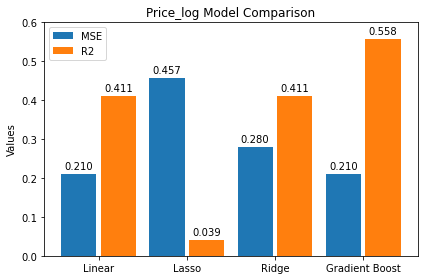

In [60]:
# Set up the plot
x = np.arange(len(models_1))
width = 0.4
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2 - 0.025, MSEs, width, label='MSE')
rects2 = ax.bar(x + width/2 + 0.025, R2s, width, label='R2')

# Add labels, title and custom x-axis tick labels
ax.set_ylabel('Values')
ax.set_title('Price_log Model Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models_1)
ax.legend()
ax.set_ylim(0, 0.6)
# Create a function to display the values on top of the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
plt.show()

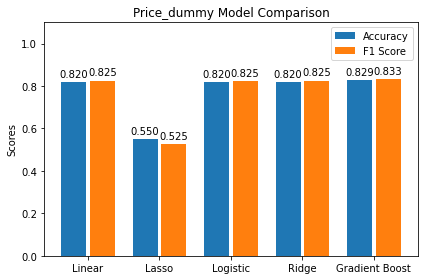

In [61]:
# Set up the plot
x = np.arange(len(models_2))
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2 - 0.025, accuracy_scores, width, label='Accuracy')
rects2 = ax.bar(x + width/2 + 0.025, f1_scores, width, label='F1 Score')

# Add labels, title and custom x-axis tick labels
ax.set_ylabel('Scores')
ax.set_title('Price_dummy Model Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models_2)
ax.legend()
ax.set_ylim(0, 1.1)
# Create a function to display the values on top of the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
plt.show()

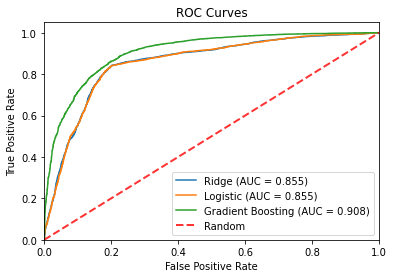

In [64]:
# Compute ROC curve and AUC for RidgeClassifier
ridge_probs = ridge_clf.decision_function(X_test)
ridge_fpr, ridge_tpr, _ = roc_curve(y2_test, ridge_probs)
ridge_auc = auc(ridge_fpr, ridge_tpr)

# Compute ROC curve and AUC for Logistic Regression
logistic_probs = logit.predict_proba(X_test)[:, 1]
logistic_fpr, logistic_tpr, _ = roc_curve(y2_test, logistic_probs)
logistic_auc = auc(logistic_fpr, logistic_tpr)

# Compute ROC curve and AUC for Gradient Boosting Classifier
gb_probs = gb_clf.predict_proba(X_test)[:, 1]
gb_fpr, gb_tpr, _ = roc_curve(y2_test, gb_probs)
gb_auc = auc(gb_fpr, gb_tpr)

# Plot ROC curves
plt.figure()
plt.plot(ridge_fpr, ridge_tpr, label='Ridge (AUC = {:.3f})'.format(ridge_auc))
plt.plot(logistic_fpr, logistic_tpr, label='Logistic (AUC = {:.3f})'.format(logistic_auc))
plt.plot(gb_fpr, gb_tpr, label='Gradient Boosting (AUC = {:.3f})'.format(gb_auc))

# Plot the random classifier (diagonal line)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random', alpha=0.8)

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

In [229]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
#
# Hyperparameters for GradientBoostingRegressor
#
gbr_params = {'n_estimators': 100,
          'max_depth': 3,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}
#
# Create an instance of gradient boosting regressor
#
gbr = GradientBoostingRegressor(**gbr_params)
#
# Fit the model
#
gbr.fit(X_train, y1_train)
#
# Print Coefficient of determination R^2
#
print("Model Accuracy: %.3f" % gbr.score(X_test, y1_test))
#
# Create the mean squared error
#
mse = mean_squared_error(y1_test, gbr.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))


Model Accuracy: 0.400
The mean squared error (MSE) on test set: 0.2855


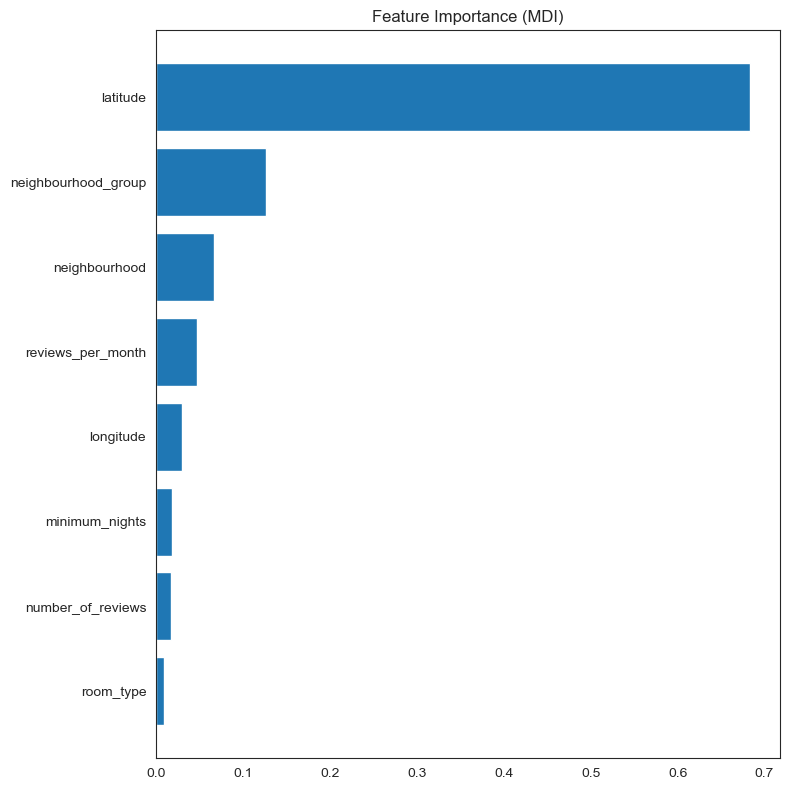

In [223]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
#
# Get Feature importance data using feature_importances_ attribute
#
feature_importance = gbr.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(8, 8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(df1.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')
result = permutation_importance(gbr, X_test, y1_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
fig.tight_layout()
plt.show()

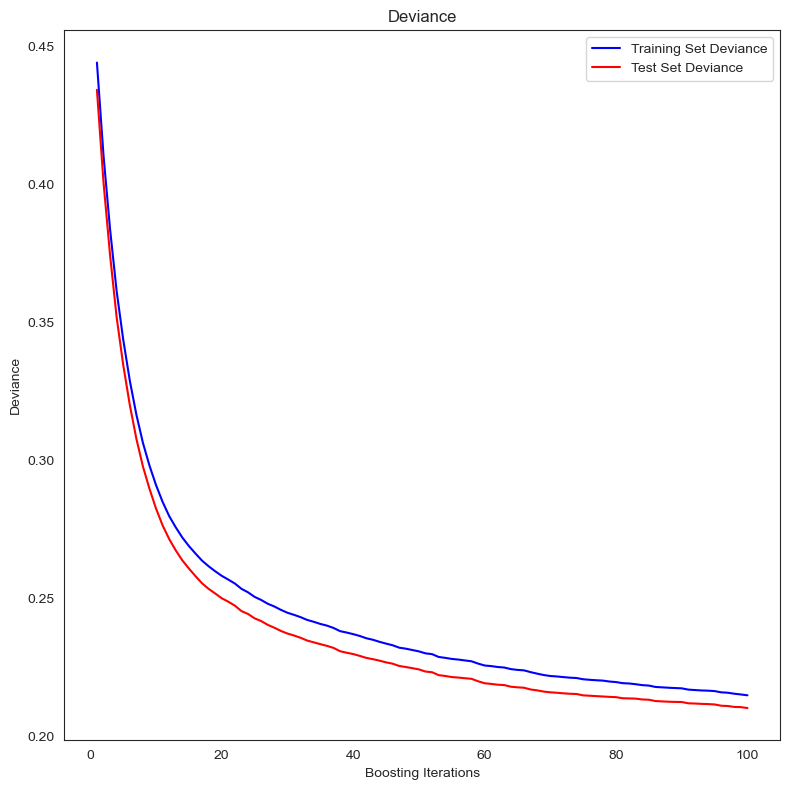

In [224]:
test_score = np.zeros((gbr_params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(gbr.staged_predict(X_test)):
    test_score[i] = gbr.loss_(y1_test, y_pred)
 
fig = plt.figure(figsize=(8, 8))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(gbr_params['n_estimators']) + 1, gbr.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(gbr_params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()